# 豆瓣演员网络分析

In [1]:
import pickle
import numpy as np
import networkx as nx

import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  #MacOS自带
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
"""数据预处理"""
# 读取数据
movies_df = pd.read_csv("DATA/movies.csv",index_col='MOVIE_ID')
person_df = pd.read_csv("DATA/person.csv",index_col='PERSON_ID')
# 保留特定列
movies_df = movies_df[['NAME', 'ACTOR_IDS', 'DIRECTOR_IDS']]
movies_df.sort_index(inplace=True)
person_df = person_df[['NAME']]
movies_df.sort_index(inplace=True)
# 清理NA
movies_df.dropna(subset=['ACTOR_IDS', 'DIRECTOR_IDS'],how='all',inplace=True)
movies_df.fillna('',inplace=True)
# 生成person列
movies_df['PERSON_IDS'] = movies_df['ACTOR_IDS'] + '|' + movies_df['DIRECTOR_IDS']
movies_df['PERSON_IDS'] = movies_df['PERSON_IDS'].map(lambda x: list(filter(None,list(set(x.split("|"))))))
# movies_df['PERSON_IDS'] = movies_df['PERSON_IDS'].str.split('|', expand=False)
# person id化
def get_person_id(persons):
    ids = []
    for person in persons:
        if len(person.split(':'))==2 and person.split(':')[1] != '':
            ids.append(person.split(':')[1])
    return ids
movies_df['PERSON_IDS'] = movies_df['PERSON_IDS'].map(get_person_id)
# 清空id列表为空或len为1的行
movies_df = movies_df[movies_df['PERSON_IDS'].map(len) > 1]

In [3]:
"""生成样本"""
SAMPLE_NUM = 1000
movies_df_sample = movies_df.sample(SAMPLE_NUM)

In [4]:
"""生成网络网络数据"""
person_series = movies_df_sample['PERSON_IDS']
nodes = []
edges = []
for group in person_series:
    nodes.extend(group)
    for person_ind1 in range(len(group)):
        # person_ind2_list = [ person_ind2 for person_ind2 in list(range(len(group)))]
        person_ind2_list = [ person_ind2 for person_ind2 in list(range(len(group))) if person_ind2 != person_ind1 ]
        edges.extend(list(map(lambda person_ind2: (group[person_ind1],group[person_ind2]),person_ind2_list)))

In [5]:
"""生成网络"""
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

In [6]:
"""邻接矩阵"""
As = nx.adjacency_matrix(graph)
print(As.todense())

/var/folders/16/d18_hlr10wg0sxr05212j1z40000gn/T/ipykernel_87617/727802146.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  As = nx.adjacency_matrix(graph)


[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [7]:
""" 度、平均度以及度分布 """
# 度
degree_dict = dict(graph.degree)
# 平均度
degree_mean = sum(degree_dict.values())/len(graph.nodes)
# 获取度分布
degree_distribute = nx.degree_histogram(graph)

In [8]:
""" 路径与距离 """
# 最短路径
node1 = list(degree_dict.keys())[0]
node2 = list(degree_dict.keys())[2]
print(nx.shortest_path(graph, source=node1, target=node2))
# print(list(nx.all_shortest_paths(graph, source=node1, target=node2)))
# 最短路径长度(距离)
print(nx.shortest_path_length(graph, source=node1, target=node2))
# 整个网络的平均距离
if nx.is_connected(graph):
    print(nx.average_shortest_path_length(graph))
else:
    print("网络未能连接...")

['1113991', '1133548']
1
网络未能连接...


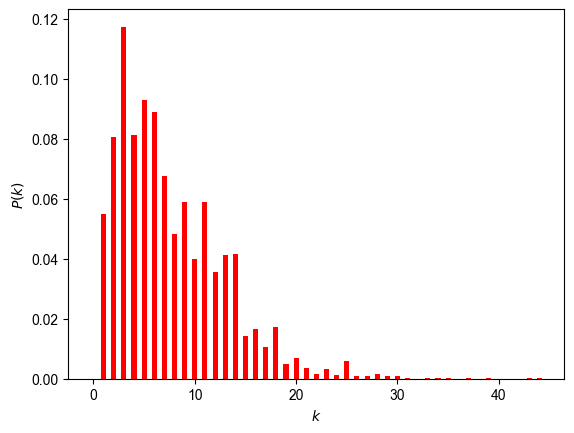

In [9]:
""" 绘制分布直方图 """
x = list(range(max(degree_dict.values())+1))
y = [i/len(graph.nodes) for i in nx.degree_histogram(graph)]
plt.bar(x, y, width=0.5, color='red')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.savefig(f"output/img/degree_distribute_{str(SAMPLE_NUM)}.png")

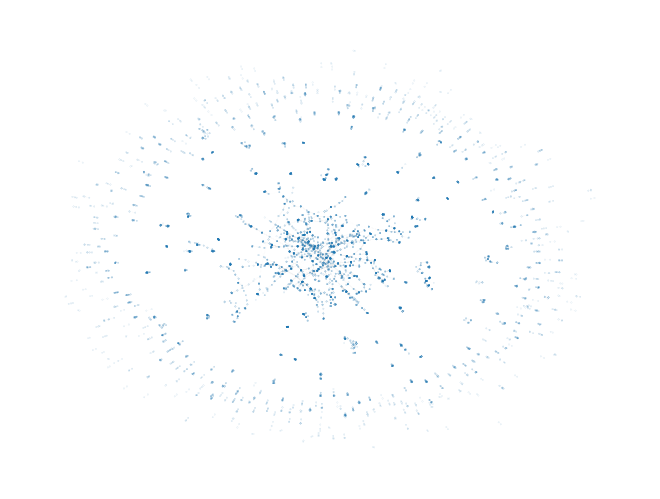

In [10]:
"""绘制网络"""
# nx.draw(graph, nodelist=degree_dict.keys(), node_size=0.01, width=0.002, with_labels=False)
nx.draw(graph, nodelist=degree_dict.keys(), node_size=[v*0.002 for v in degree_dict.values()], width=0.002, with_labels=False)
plt.savefig(f"output/img/graph_{str(SAMPLE_NUM)}.pdf")

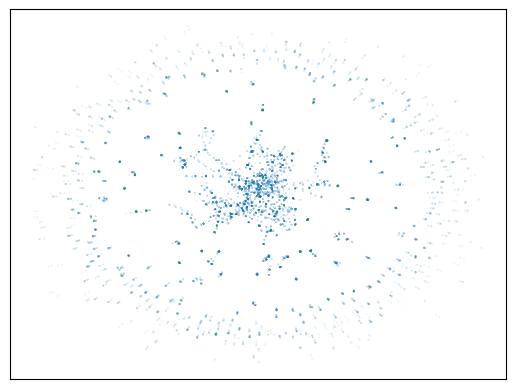

In [11]:
"""只绘制节点"""
nx.draw_networkx_nodes(graph, pos=nx.spring_layout(graph), nodelist=degree_dict.keys(), node_size=[v*0.002 for v in degree_dict.values()])
plt.savefig(f"output/img/graph_nodes_{str(SAMPLE_NUM)}.pdf")